# Object localization using Vision Transformer (ViT)

**Remember to enable GPU**

This notebook demonstrates how to implement and train a ViT to perform object localization.

## Your main task
See if you can match the code against the theory presented in the slides of Lecture 12 (Vision Transformers).

## The Vision Transformer
The ViT uses a Transformer-like architecture over patches of the image. An image is split into fixed-size patches, each of them is then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. In order to perform classification, a standard approach of adding an extra learnable “classification token” to the sequence is used.

See lecture 12 for more details.

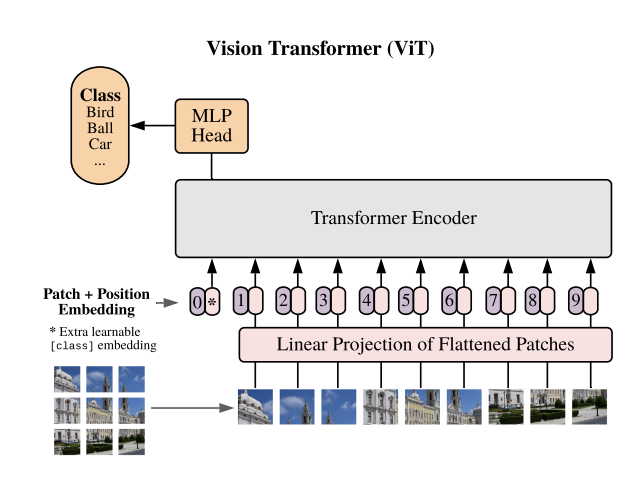


In [6]:
#Loading libraries, we are using keras
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil
import torch

## 1. Download data
We will be training a ViT to localize airplanes. For this purpose we will be using airplane images from the CIFAR101 dataset. These have been annotated with bounding boxes as well. Note that there is exactly one plane per image, so we are dealing with *object localization* (single object) and not *object detection* (multiple objects).

In [21]:
# Path to images and annotations
path_images = "/101_ObjectCategories/airplanes/" # Defining folder structures of dataset, we are usign caltechs plane dataset
path_labels = "/Annotations/Airplanes_Side_2/" # Defining folder structure and path to labels

path_to_downloaded_file = keras.utils.get_file(
    fname="caltech_101_zipped",
    origin="https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip",
    extract=True,
    archive_format="zip",  # file formmat
    cache_dir=".",  # cache and extract in current directory
)

# Extracting  files found inside zip file
shutil.unpack_archive("/datasets/caltech-101/101_ObjectCategories.tar.gz", ".") # UNAPCK ZIP FILE
shutil.unpack_archive("/datasets/caltech-101/Annotations.tar", ".")

# list of paths to images and annotations
image_paths = [
    img for img in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, img))
] #  Creating list containing path to images
label_paths = [
    cords for cords in os.listdir(path_labels) if os.path.isfile(os.path.join(path_labels,cords))
] #  Creating list containing path to labels which contains coordinates for bounding boxes

image_paths.sort() # Sorting the images according to name
label_paths.sort() # Sorting the labels according to name, ensuring same location of corresponding labels and images in  the arrays

image_size = 112  # resize input images to this size

images, targets = [], [] # empty lists

# loop over the annotations and images, preprocess them and store in lists
for i in range(len(image_paths)):
    # Access bounding box coordinates
    bounding_box_coords= scipy.io.loadmat(path_labels + label_paths[i])["box_coord"][0] # Loading labels, which are coordinates for box enclosing the objects detected

    top_left_x, top_left_y = bounding_box_coords[2], bounding_box_coords[0] # the arrangement of coordinates is accordingly, meaning the y coordinates comes first
    bottom_right_x, bottom_right_y = bounding_box_coords[3], bounding_box_coords[1]

    image = keras.utils.load_img(
        path_images + image_paths[i],
    ) # Loading corresponding images for the coordinate labels we just loaded
    (w, h) = image.size[:2]

    # resize images
    #if i < int(len(image_paths) * 0.8):
    # resize image if it is for training dataset
    image = image.resize((image_size, image_size)) # Smaller images are easier to process as these are less computationally heavy and they need to be of the same size

    # convert image to array and append to list
    images.append(keras.utils.img_to_array(image))  # Keras and pytorch takes tensor as input but first we convert these images to arrays do som e preprocessing and then later convert to tensor when sent into network

    # apply scaling to bounding boxes, due to rezing of the images, and append these to a list
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )

# Split to train and test datasets allocating 80%  to training /validation and 20% for test
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

### 1.1 Question
1. What are the targets for this problem (i.e., what do the number on `y_train` and `y_test` represent?)

## 2. Splitting the input image into patches
The ViT divides the input image into patches. The reason is the Transformers operate on sequential data. We can create such a sequence by ordering the patches as a sequence.

In [22]:
# Transformers gets multiple patches as input.
# Here, the patching is implemented as a callable class
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size # saving

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

Example usage:

Image size: 112 X 112
Patch size: 32 X 32
9 patches per image 
3072 elements per patch


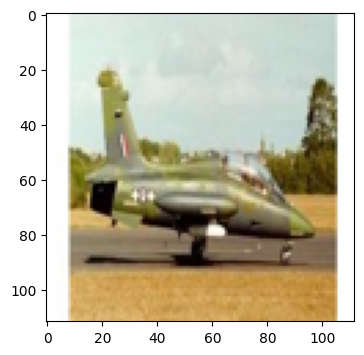

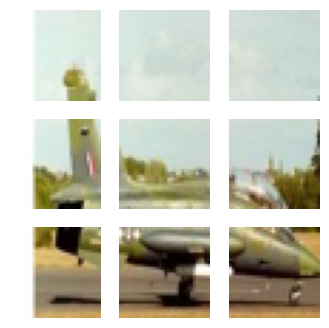

In [23]:
patch_size = 32  # Size of patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]])) # Creating patches of 32 x 32 of the training images and converting these to tensors. Kearas and pytorch takes tnesors as input
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch") # print patch shape

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## 4. Patch encoding
Each patch is encoded using a linear/dense layer. Recall that the attention mechanism of the transformer is *permutation invariant*, i.e., changing the order of the tokens in the input sequence doesn't change the output of the attention operation. To resolve this, we add a *positional embedding vector* to each token in the sequence. In our implementation we use Keras' built-in [Embedding layer](https://keras.io/api/layers/core_layers/embedding/), which is simply turns a positive integers (index of each patch in the sequence) into dense vectors of fixed size.

In [24]:
# Encoding pathches using the same function as above where we create the patches  however with additonal variable declared as we need to do an encoding of our inputs for transformers this means we encode the patches relative to their position
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1) # defining the popotion by using a numerical sequence in range 0-number of patches in the incrament delta delta where each is assigned
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## 5. ViT implementation
Refer to lecture 12 for an explanation of the Transformer architecture.

In short, each transformer block consists of
- [a multi-head attention block (for self-attention) ](https://keras.io/api/layers/attention_layers/multi_head_attention/)
- first skip connection
- [layer normalization](https://keras.io/api/layers/normalization_layers/layer_normalization/)
- an MLP (see below)
- second skip connection

We define the MLP ourselves. Here we choose to use dropout (for regularization) and an activation function, called a SiLU (similar to a ReLU, but without the discontinuity at 0).

In [25]:
# Generic MLP for encoding patches
def mlp(x, hidden_units, dropout_rate=0.25): # dense layer calculate dot product
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.silu)(x) #silu is a very typical ativation function for ViTs
        x = layers.Dense(units, activation=tf.nn.silu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

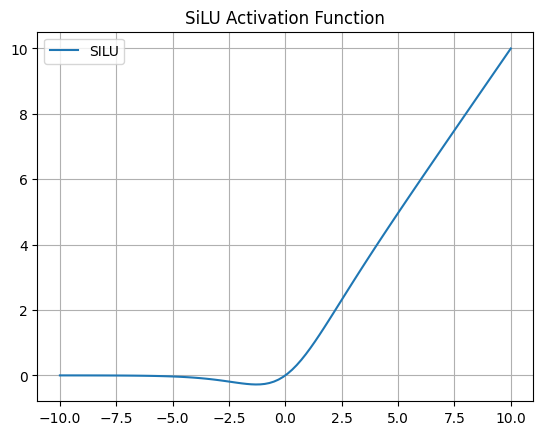

In [26]:
# Visulization of SiLU
import torch

def silu(input):
    return input * torch.sigmoid(input)
# Generating data
x_data = np.linspace(-10,10,100)
y_data = silu(torch.tensor(x_data))

# Graph silu should we include derivative
plt.plot(x_data, y_data, )
plt.title('SiLU Activation Function')
plt.legend(['SILU'])
plt.grid()
plt.show()

In [27]:
def vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):

    inputs = layers.Input(shape=input_shape)

    # Patch generator, as defined above (callable)
    patches = Patches(patch_size)(inputs)

    # Patch encoder, as defined above (callable)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) # encode the patches relative to their postion

    # Create multiple transformer blocks.
    for i in range(transformer_layers):

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(encoded_patches, encoded_patches)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)

    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    # Final four neurons that output bounding box
    bounding_box = layers.Dense(4)(
        features
    )

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

### 5.1 Questions
1. Why does the MultiHeadAttention layer take two inputs?
2. The last (dense/liner) layer has no activation function. Why? Hint: The layer outputs four numbers. What do these numbers represent?

## 6. Model training

In [29]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model with MSE loss (because it is regression)
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())
    model.summary()

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history

input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4

# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers

history = []
num_patches = (image_size // patch_size) ** 2

object_detection = vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    object_detection, learning_rate, weight_decay, batch_size, num_epochs
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 112, 112, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches_2 (Patches)       │ (None, None, 3072)     │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder_1           │ (None, 9, 64)          │        197,248 │ patches_2[0][0]        │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 9, 64)          │         66,368 │ patch_encoder_1[0][0], │
│ (MultiHeadAttention)      │                        │                │ patch_encoder_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 9, 64)          │              0 │ multi_head_attention_… │
│                           │                        │                │ patch_encoder_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 9, 64)          │            128 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 9, 128)         │          8,320 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 9, 128)         │         16,512 │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 9, 128)         │              0 │ dense_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 9, 64)          │          8,256 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 9, 64)          │          4,160 │ dense_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 9, 64)          │              0 │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 9, 64)          │              0 │ dropout_20[0][0],      │
│                           │                        │                │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 9, 64)          │         66,368 │ add_9[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 9, 64)          │              0 │ multi_head_attention_… │
│                           │                        │                │ add_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6

 Total params: 9,965,892 (38.02 MB)

 Trainable params: 9,965,892 (38.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 146ms/step - loss: 1.0142 - val_loss: 0.0250
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0599 - val_loss: 0.0050
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0387 - val_loss: 0.0040
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0300 - val_loss: 0.0023
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0270 - val_loss: 0.0022
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0226 - val_loss: 0.0018
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0206 - val_loss: 0.0013
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0196 - val_loss: 0.0017
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0189 - val_loss: 0.0018
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0162 - val_loss: 0.0020
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0171 - val_loss: 0.0011
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/s

## 7. Model evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
coordinates of detected object:  [0.12998806 0.20241602 0.8718233  0.8054813 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
coordinates of detected object:  [0.12977163 0.20234914 0.87184167 0.8051752 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
coordinates of detected object:  [0.12965477 0.2022101  0.87187755 0.80515456]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
coordinates of detected object:  [0.12980896 0.20231988 0.87192374 0.80549407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
coordinates of detected object:  [0.13000733 0.20249961 0.87181854 0.8052434 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
coordinates of detected object:  [0.13014193 0.20243652 0.8720201  0.8053795 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
coordinates of detected object:  [0.13010058 0.20251125 0.8719188  0.8051901 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
coordinates of detected object:  [0.130075   0.20250773 0.87180024 0.80512977]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
coordinates of detected ob

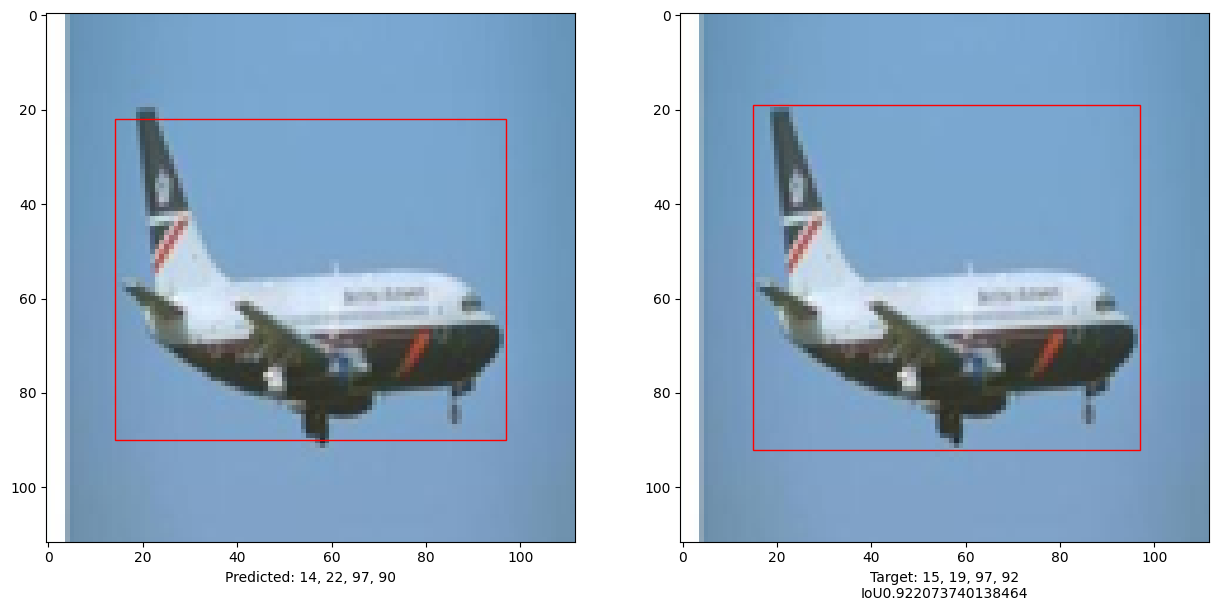

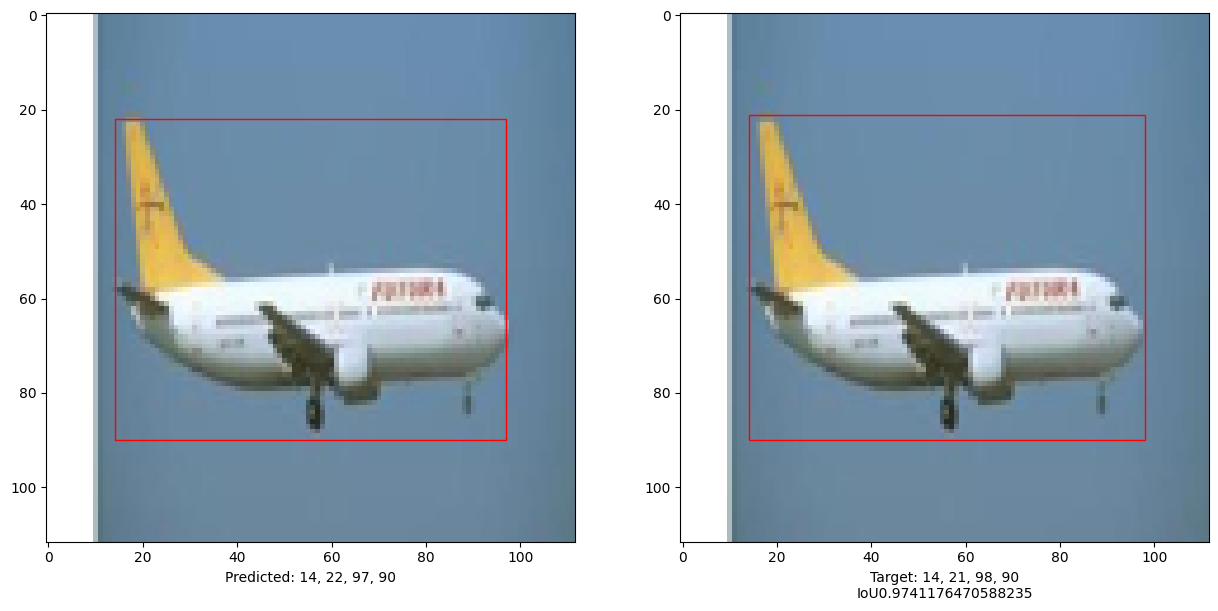

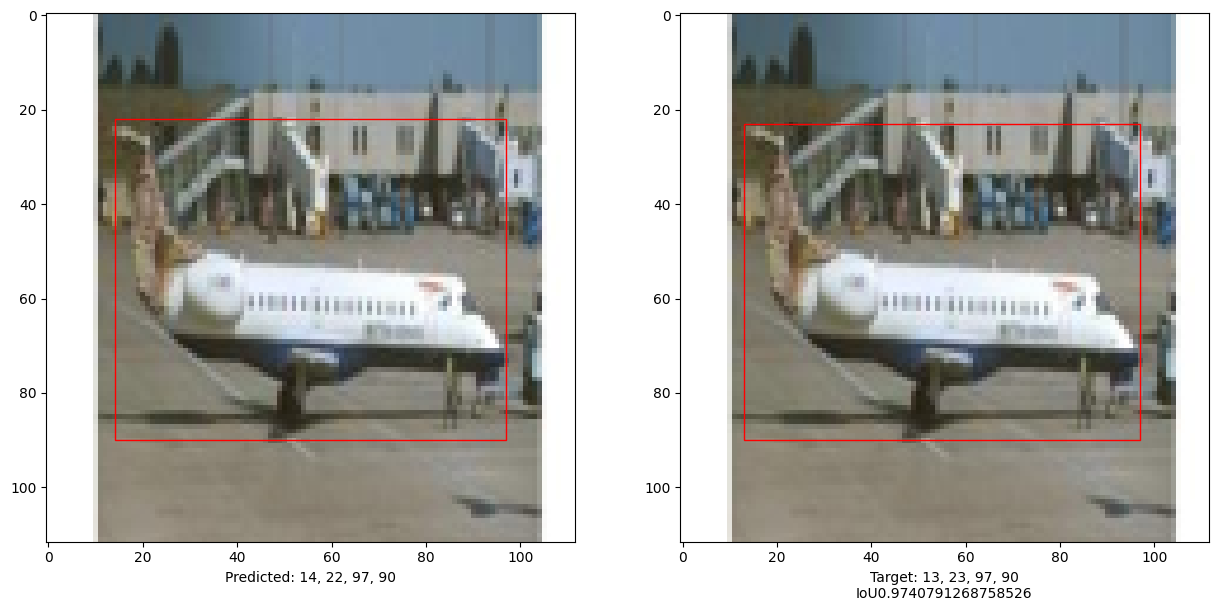

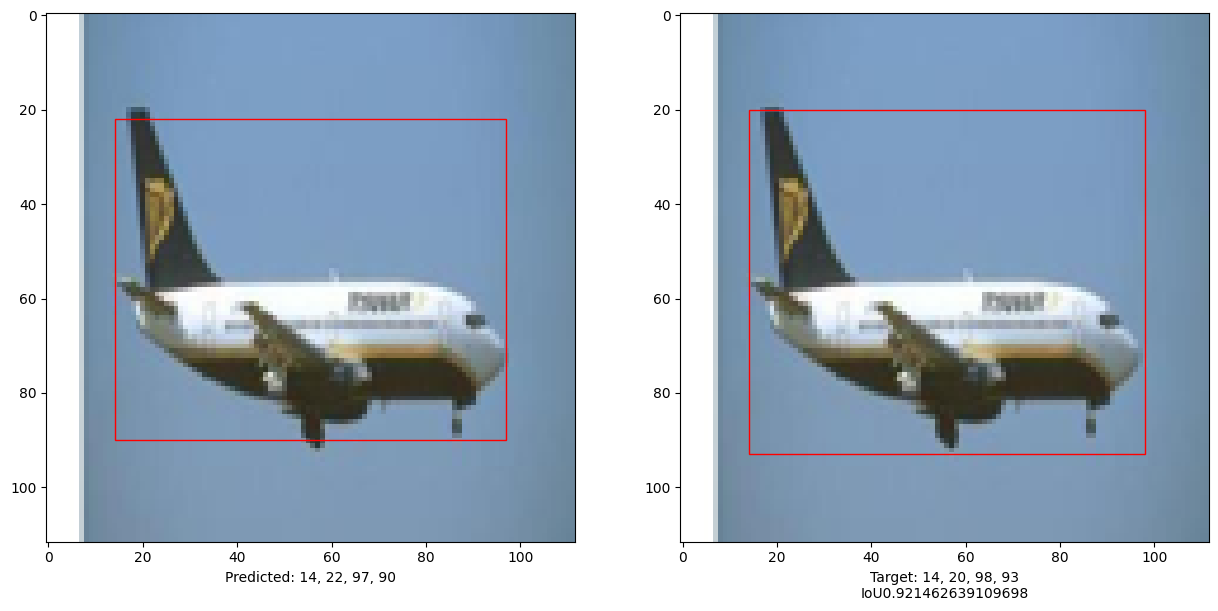

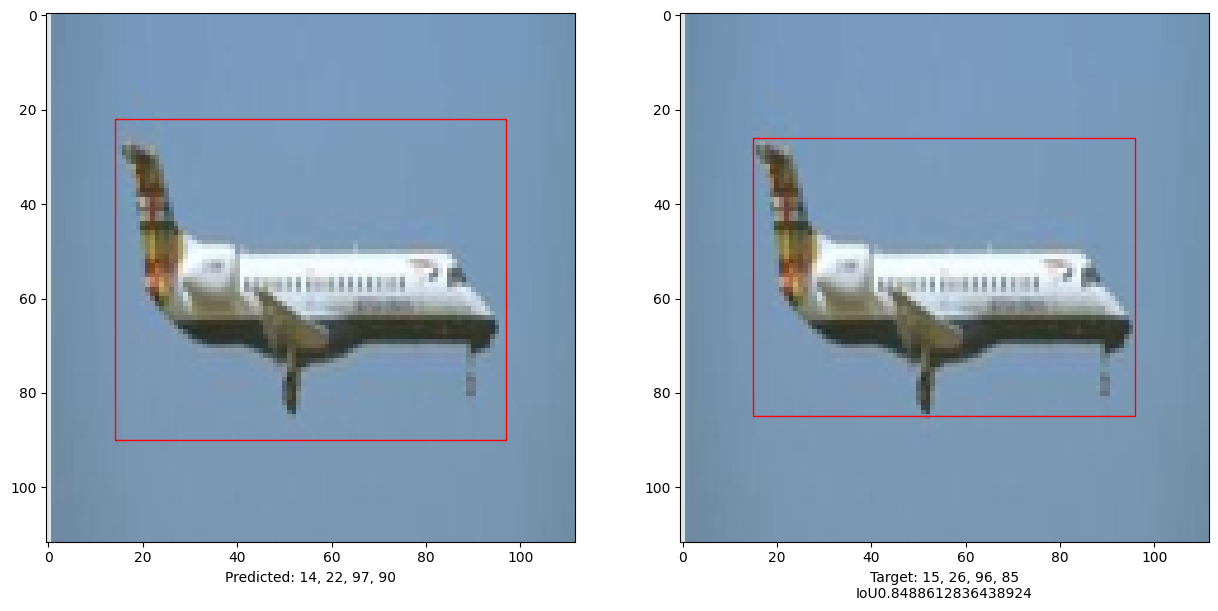

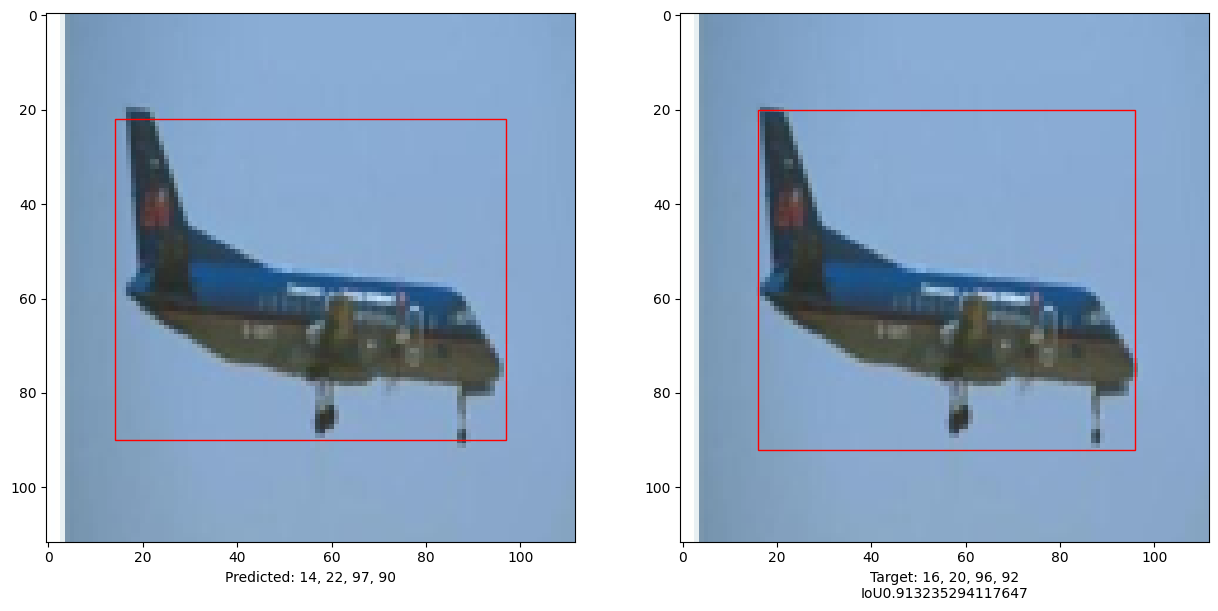

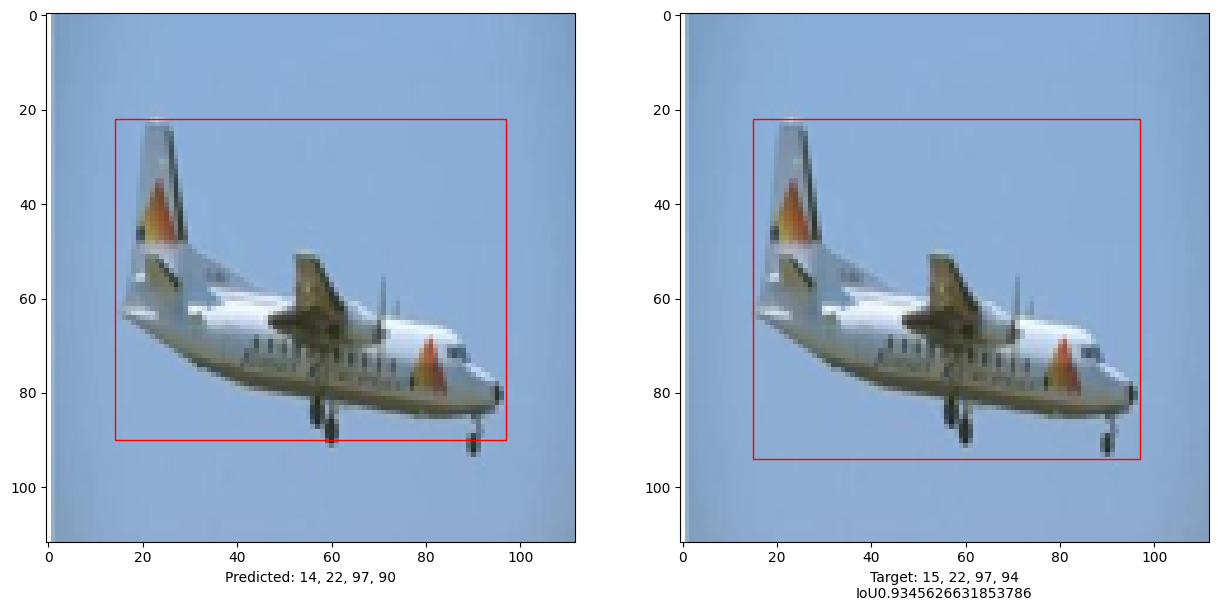

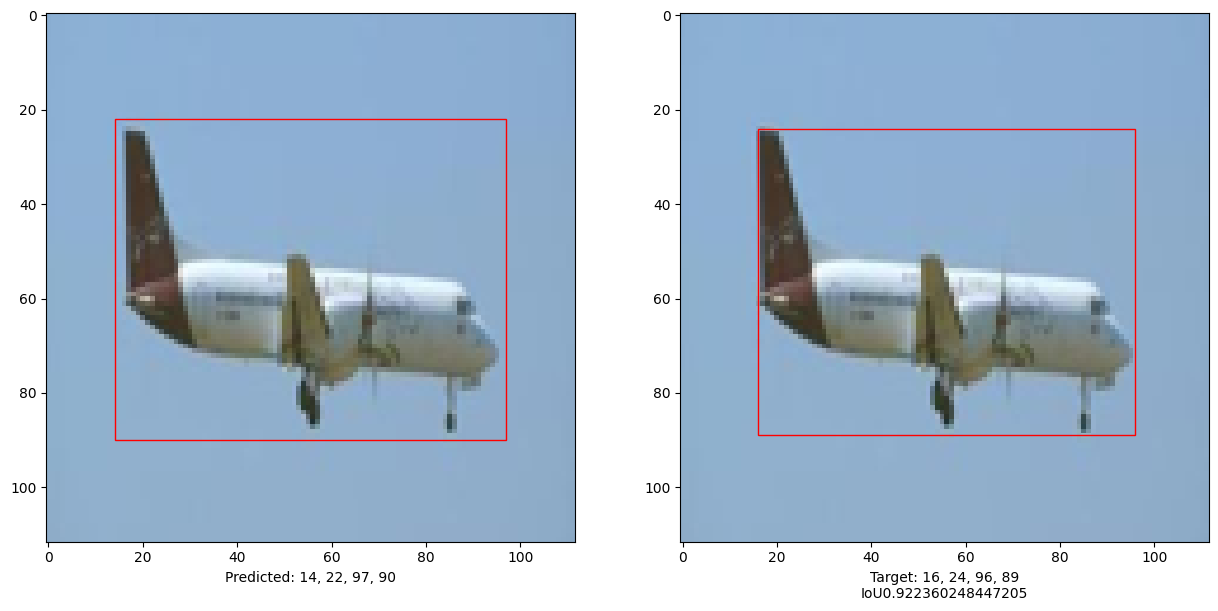

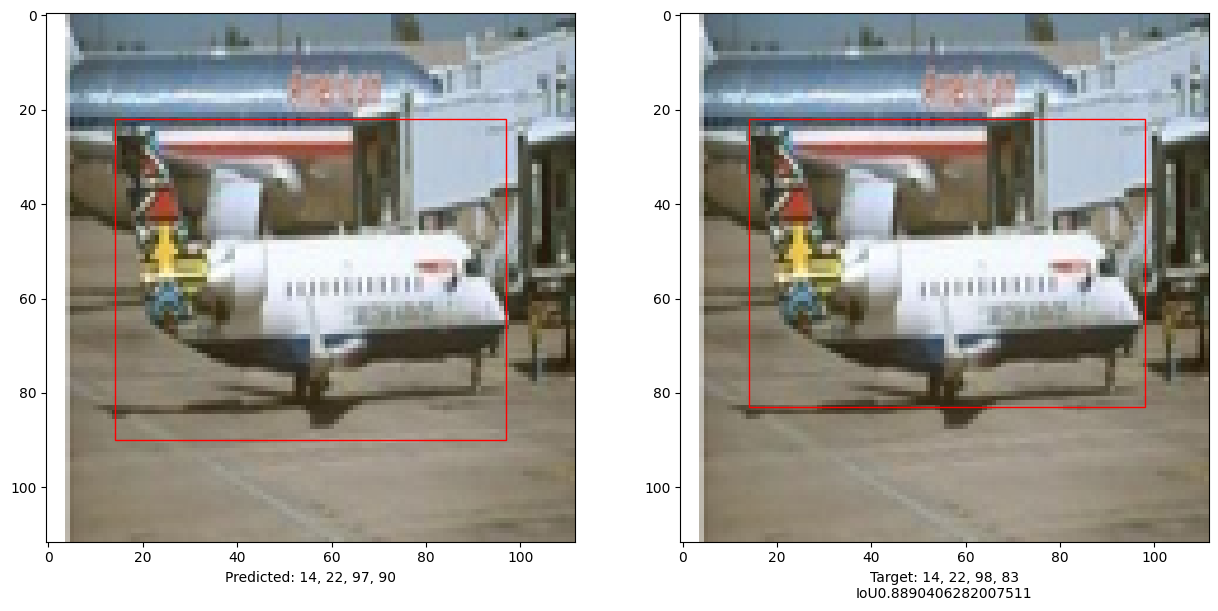

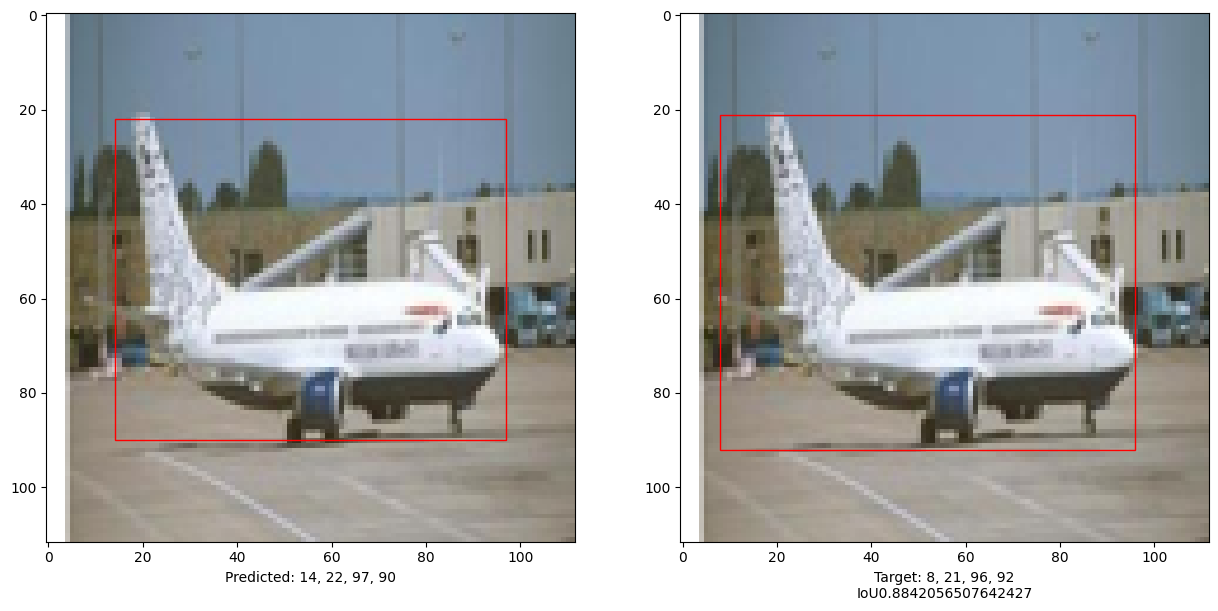

In [31]:
import matplotlib.patches as patches

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = object_detection.predict(input_image)[0]
    print("coordinates of detected object: ", preds)

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    bounding_box = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(bounding_box)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    bounding_box = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(bounding_box)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()